In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from ast import literal_eval
from itertools import chain
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

**IMPORTING DATA**

In [2]:
train = pd.read_csv('nbme/train.csv')
test = pd.read_csv('nbme/test.csv')
patient_notes = pd.read_csv('nbme/patient_notes.csv')
features = pd.read_csv('nbme/features.csv')

### DATA EXTRACTION AND UNDERSTANDING

**PATIENT NOTES**

In [3]:
# Importing patient Notes Data 
print(patient_notes.shape)
print(patient_notes.nunique())
patient_notes.head()

(42146, 3)
pn_num        42146
case_num         10
pn_history    42146
dtype: int64


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...



1. **Dataset Information**: 
   - Shape of the dataset: (42146, 3), indicating 42146 rows and 3 columns.
   - Unique values in each column:
     - `pn_num`: 42146 unique values, likely representing unique patient note numbers.
     - `case_num`: 10 unique vasibly indicating different cases or categories.
     - `pn_history`: 42146 unique values, presumably containing the patient notes or histories.

2. **Data Preview**:
   - The `patient_notes.head()` function displays the first few rows of the dataset, showing columns `pn_num`, `case_num`, and `pn_history`.
   - Each row seems to represent a patient note, with details such as age, gender, symptoms, and medicses or types.

**FEATURES**

In [4]:
# Importing Features Data Representing different kind of features for each clinical case 
print(features.shape)
print(features.nunique())
features.head()

(143, 3)
feature_num     143
case_num         10
feature_text    131
dtype: int64


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


**TRAIN DATA**

In [5]:
# Importing train Data (Each row represent a Unique Identifier for Patient-Feature Pair)
print(train.shape)
print(train.nunique())
train.head()

(14300, 6)
id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [6]:
# Assuming 'train' is your DataFrame
null_count = train.isnull().sum().sum()
print("Total number of observations with null values:", null_count)

Total number of observations with null values: 0


**Observations in Train Data:**
- There are total of 6 columns and 14300 rows in train data.
- 10 unique cases and 1000 unique patient ids are present.
- Multilple annotations and locations are present in single rows.

**MISSING VALUES**

In [7]:
print("Number of Empty annotions and locations = ", sum(train["location"] == '[]'))

Number of Empty annotions and locations =  4399


**VOCABULARY SIZE BEFORE PREPROCESSING**

In [30]:
import pandas as pd
from nltk.tokenize import word_tokenize

# Load CSV file into a DataFrame
patient_notes = pd.read_csv('nbme/patient_notes.csv')

# Convert all columns to strings
patient_notes = patient_notes.astype(str)

# Initialize an empty list to store combined text
combined_texts = []

# Concatenate text from multiple columns into a single text column for each row
for index, row in patient_notes.iterrows():
    combined_texts.append(' '.join(row))

# Combine all rows' text into a single string
combined_text = ' '.join(combined_texts)

# Tokenize the combined text
tokens = word_tokenize(combined_text)

# Calculate vocabulary size
vocab_size = len(set(tokens))
print("Vocabulary Size of patient_notes DataFrame:", vocab_size)

Vocabulary Size of patient_notes DataFrame: 123549


**VOCABULARY SIZE BEFORE PREPROCESSING: 123549**

### EXPLORATORY DATA ANALYSIS

In [32]:
#value counts
temp = patient_notes.groupby('case_num').count()['pn_history'].reset_index().sort_values(by='pn_history', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,pn_history
3,3,9753
5,5,6909
4,4,5405
9,9,5151
8,8,4196
7,7,4101
0,0,2268
2,2,1958
6,6,1597
1,1,808


<Axes: xlabel='case_num', ylabel='count'>

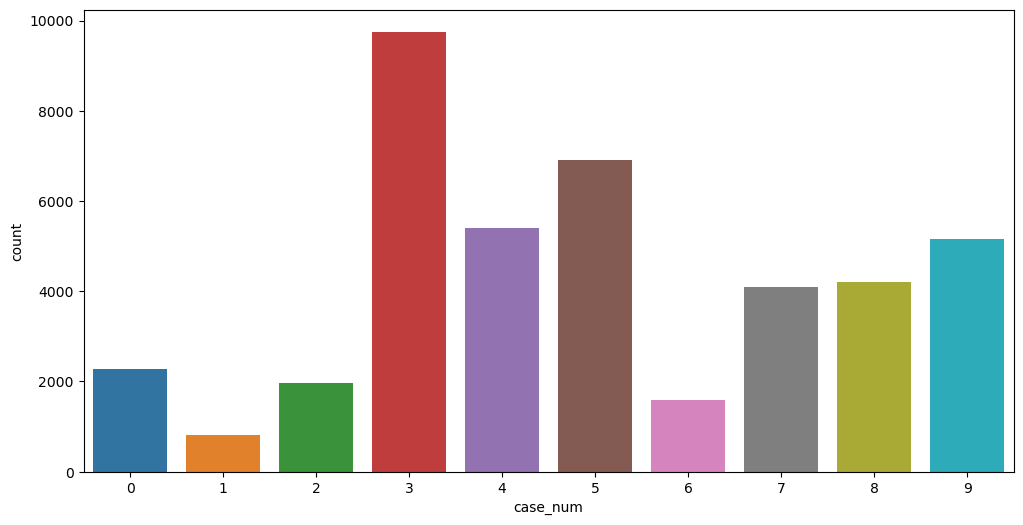

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x='case_num', data=patient_notes)

**MOST COMMON**

In [34]:
#Most common word in the target Selected
patient_notes['temp']= patient_notes['pn_history'].apply(lambda x: str(x).split())
top= Counter([item for sublist in patient_notes['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns=["Common_words", 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,and,134345
1,with,95369
2,of,92239
3,no,82617
4,a,75820
5,the,70754
6,in,70346
7,has,68659
8,is,62703
9,for,57314


## PREPROCESSING

**REMOVING STOPWORDS**

In [35]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
patient_notes['temp'] = patient_notes['temp'].apply(lambda x: remove_stopword(x))

**COMMON WORDS AFTER THE STOPWORD REMOVAL**

In [36]:
top = Counter([item for sublist in patient_notes['temp'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=["Common_words",'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,pain,40083
2,2,38697
3,No,35750
4,none,33490
5,denies,30296
6,-,22866
7,last,22159
8,3,21139
9,weeks,20609
10,PMH:,19741


**Distribution of top n-grams for pn_history**

In [37]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    
    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
common_words = get_top_Nwords(patient_notes['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


**Bigram distribution**

In [39]:
common_words = get_top_Nwords(patient_notes['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


In [40]:
common_words = get_top_Nwords(patient_notes['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

year old female 4388
sexually active boyfriend 4242
illicit drug use 3540
uncle bleeding ulcer 3413
ros negative pmh 3362
sexually active husband 2878
35 year old 2872
difficulty falling asleep 2853
pmh psh meds 2584
lmp weeks ago 2265
year old male 2173
chest pain sob 1990
use sexually active 1947
drugs sexually active 1893
fh uncle bleeding 1788
denies chest pain 1781
pmh psh fh 1745
15 30 minutes 1657
drug use sexually 1607
mr hamilton 35 1476


## PREPROCESSING

In [44]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download NLTK resources (only required if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
patient_notes = pd.read_csv('nbme/patient_notes.csv')
features = pd.read_csv('nbme/features.csv')
train= pd.read_csv('nbme/train.csv')

# Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Text normalization
def normalize_text(tokens):
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    return tokens

# Lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

# Preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = tokenize_text(text)
    
    # Text normalization
    normalized_tokens = normalize_text(tokens)
    
    # Lemmatization
    lemmatized_tokens = lemmatize_text(normalized_tokens)
    
    # Remove stopwords
    cleaned_tokens = remove_stopwords(lemmatized_tokens)
    
    # Join tokens back into a string
    processed_text = ' '.join(cleaned_tokens)
    
    return processed_text

# Apply preprocessing to 'pn_history' column in patient_notes DataFrame
patient_notes['pn_history'] = patient_notes['pn_history'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
# Apply preprocessing to 'pn_history' column in patient_notes DataFrame
patient_notes['pn_history'] = patient_notes['pn_history'].apply(preprocess_text)

**VOCABULARY SIZE AFTER PREPROCESSING**

In [47]:
# Tokenize the preprocessed text
preprocessed_tokens = patient_notes['pn_history'].apply(word_tokenize)

# Flatten the list of token lists into a single list
all_tokens = [token for sublist in preprocessed_tokens for token in sublist]

# Calculate vocabulary size
vocab_size = len(set(all_tokens))
print("Vocabulary Size after Preprocessing:", vocab_size)

Vocabulary Size after Preprocessing: 62843


**VOCABULARY SIZE AFTER PREPROCESSING: 62843**